#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H=13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
E = 210e9

In [20]:
E*Ar

16991625880.187403

In [21]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [22]:
DT=np.diag(diag_DT) # (35) in [2]

In [23]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [24]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [25]:
CT=np.diag(diag_CT)

In [26]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [27]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [28]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [29]:
rng = np.random.default_rng()

In [30]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [32]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.58244582,  0.34700881,  0.73507942],
       [-0.13022207,  0.93245497, -0.3370014 ],
       [-0.80237091,  0.10056149,  0.5882927 ]])

In [33]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.006322


In [34]:
Ret.shape

(50, 3, 3)

In [35]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [36]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64))) 
    return ans.T

In [37]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000813


In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-2.56034787e+03, -2.07778131e+03,  1.21658082e+03],
       [-1.63623710e+03, -5.22340826e+03,  3.43231530e+03],
       [-2.26108662e+03, -8.17812148e+02,  1.48653779e+02],
       [-3.09763369e+03, -8.39181788e+03,  9.55291368e+03],
       [-1.71658039e+04, -9.05747328e+03, -6.00654424e+03],
       [-2.30129233e+04, -1.00300819e+04,  2.22332278e+02],
       [ 1.27199878e+01,  1.30476677e+04,  9.08459761e+03],
       [ 7.98756093e+02, -4.22697834e+03,  1.25045345e+03],
       [-6.61325207e+02,  1.01056125e+04, -3.55662990e+02],
       [ 1.09493425e+04,  5.73413075e+03, -1.98794169e+03],
       [ 4.50307118e+03, -4.17942989e+03,  4.59623158e+03],
       [ 2.93761656e+03, -6.33950789e+03, -1.02712720e+04],
       [-3.07730868e+03,  2.58343265e+04,  9.54805460e+03],
       [-6.29080022e+03,  3.82949574e+03,  5.70876239e+02],
       [-1.38646222e+03,  3.43846287e+02,  3.72058779e+02],
       [-1.60258285e+04, -7.79358002e+03, -4.28571874e+03],
       [-4.20780881e+03,  6.95491668e+02

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000507


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000461


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000115


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 1.37216291e+00,  3.58249228e-01, -1.51351477e-01],
       [-9.86093285e-01, -2.00179544e+00, -1.05332632e-01],
       [ 9.65066435e-01, -1.00547521e+00, -7.84567968e-01],
       [-2.80400574e-01, -6.14084333e-01,  3.65397172e-01],
       [ 8.80858052e-01,  1.41556537e-01, -3.52616510e-01],
       [ 7.60230646e-01, -1.72781214e+00,  2.89596750e-01],
       [-4.72943480e-01, -9.84843111e-01, -9.75074043e-01],
       [ 3.37432820e-01,  7.23438537e-01, -9.36357474e-01],
       [-8.36292666e-01,  9.77720950e-01,  1.18023046e-03],
       [ 2.46483400e+00, -6.61910529e-01, -7.02901237e-01],
       [ 5.69679861e-01, -7.75972365e-01, -1.07602971e+00],
       [-1.07924893e+00,  5.09335687e-01, -9.53909370e-01],
       [-1.16144569e+00,  6.29423752e-02,  9.93656559e-01],
       [ 2.01947254e-01,  1.68705070e-01,  1.93199016e+00],
       [-7.32400305e-01,  1.13697035e+00,  2.90008646e-01],
       [ 1.34376778e+00,  6.79316482e-01, -2.19068280e+00],
       [-5.69843029e-01,  3.90326617e-01

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000467


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002124


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.004911


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 9.97897093e-03,  1.09286233e+00, -6.98494299e-01],
       [-1.51010945e+00, -2.66838752e-01,  2.34400562e-01],
       [ 5.21774188e-01, -8.20995939e-01,  4.95449947e-01],
       [-2.88344767e-01, -1.01022264e+00,  3.39718113e-01],
       [ 6.23203392e-01, -3.90085394e-01,  4.47081312e-01],
       [ 8.94068101e-01, -3.05902933e+00, -8.13698549e-02],
       [-2.31790057e-01, -6.80615492e-01, -4.35086028e-01],
       [-2.03722112e-01, -1.43103342e+00, -9.88009084e-01],
       [ 1.05537960e+00, -1.64836378e+00, -1.65467354e+00],
       [ 8.36156541e-01, -1.70175656e+00, -9.24343045e-01],
       [-8.13337572e-01,  5.01616405e-01,  5.93357965e-01],
       [ 6.03820596e-01,  1.45545044e+00, -3.79537799e-01],
       [ 1.13738291e+00,  1.23036104e-02,  6.20785229e-06],
       [-9.07717278e-02,  8.98179673e-01,  1.35045380e-01],
       [-2.53822627e-01,  2.07572798e+00, -1.15052871e+00],
       [-2.58794844e-01, -1.35374699e+00,  8.12426717e-01],
       [-3.14106633e-02,  1.70154666e+00

In [63]:
def d_s(f,a,b,c,Ret,omega, force, flag=0): # here
    
    fun = f(a,b,c,Ret,omega, force) 
    
    if flag==1:
        fun+=-np.dot(Ret,force)
    elif flag==2:
        fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [64]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3],flag=2)

array([[ 1.40243276e-04,  2.17266881e-04, -4.75313382e-05,
         2.22287249e-04, -4.32396491e-06,  2.75549638e-04,
         2.23571642e-04,  2.68448072e-04, -2.25042890e-04,
        -2.35297333e-05,  2.05625257e-04, -5.43530271e-05,
        -1.28043214e-04,  2.36642130e-04,  4.17301104e-05,
         1.52872086e-04,  2.73780692e-04, -1.15754290e-04,
        -1.48021446e-04,  2.16315294e-04,  2.62643704e-04,
         1.61860778e-04,  7.76621921e-05,  5.93003869e-05,
         2.59530042e-04, -2.52776805e-04,  2.78453608e-04,
        -1.94898644e-04, -2.52273078e-04, -1.29798519e-04,
         8.68442082e-05,  3.83070142e-05,  1.78309724e-04,
         2.85690970e-04,  5.72173404e-05,  2.92197625e-04,
         1.55006311e-04,  1.34922527e-04, -1.26030899e-04,
         1.43357743e-04,  1.24443564e-04,  2.59225055e-05,
         8.69505793e-05,  2.27356704e-04,  2.33193272e-04,
         2.74453977e-04, -1.01224450e-04, -2.77780341e-04,
         8.08263005e-05, -1.40618226e-04],
       [-5.23

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.002739


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force,flag=1).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[-1.98737595e-06, -1.52289440e-06,  1.17527521e-06,
         5.63614985e-07, -8.94206874e-07,  1.28674523e-06,
         1.00538053e-06, -1.55601010e-06, -1.14539880e-07,
         2.85255387e-06,  1.56878984e-07, -8.94878561e-08,
        -3.54059874e-07,  6.64021558e-08,  8.72836304e-07,
        -3.75201622e-06, -1.16906940e-06,  6.75146503e-07,
        -3.61536220e-07,  2.18493602e-07,  1.51883647e-06,
         9.51849490e-08, -1.82767846e-06, -1.15794212e-06,
        -7.01910677e-07, -1.50055365e-06, -1.77316709e-07,
         7.46690435e-07,  5.09376090e-07,  6.14714452e-07,
         6.52686850e-07,  1.06197545e-06, -1.51706337e-06,
        -7.58180020e-07, -8.96310499e-07, -1.44885538e-06,
        -7.40555320e-08,  5.43940628e-07, -4.10083492e-06,
         1.00938613e-06,  1.92738221e-07,  3.27053849e-07,
        -3.28041797e-08, -8.28784745e-07,  3.79194607e-07,
        -4.31607696e-09, -2.75999404e-08, -1.59735718e-06,
        -2.57040761e-06, -3.47968893e-07],
       [ 1.57

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 2.56034787e+03,  1.63623710e+03,  2.26108662e+03,
         3.09763369e+03,  1.71658039e+04,  2.30129233e+04,
        -1.27199878e+01, -7.98756093e+02,  6.61325207e+02,
        -1.09493425e+04, -4.50307118e+03, -2.93761656e+03,
         3.07730868e+03,  6.29080022e+03,  1.38646222e+03,
         1.60258285e+04,  4.20780881e+03, -1.78380894e+03,
        -8.88905716e+03, -2.60010430e+03,  9.79230585e+03,
        -1.17609521e+04,  4.48276069e+03, -4.25286486e+03,
        -4.54712329e+03,  6.79769709e+03, -1.53909035e+04,
         9.16212204e-02, -2.97662075e+03, -1.00436335e+04,
        -1.00671150e+03, -3.34606015e+03,  4.12162702e+03,
         1.09775621e+03, -3.40742181e+03, -7.41595549e+02,
        -9.25222935e+02,  9.12324775e+03, -1.15161649e+03,
         9.22950814e+02, -1.07340053e+04, -3.29525524e+02,
         4.28835094e+03, -9.37671217e+03,  5.52938796e+02,
        -4.73558137e+03, -4.53413804e+03,  3.55029472e+04,
         6.94030294e+03,  3.51187661e+04],
       [ 2.07

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.004563


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[ 1.64465371e+02, -4.75282521e+02,  3.10816822e+02],
       [-8.89944961e-01, -7.16372650e+02,  7.17262597e+02],
       [-3.87673461e+02, -1.09959195e+02,  4.97633432e+02],
       [ 4.02744855e+01,  1.14364384e+02, -1.54638951e+02],
       [-4.69783159e+01, -4.55448471e+02,  5.02426881e+02],
       [-1.84225451e+02,  8.17651775e+02, -6.33425956e+02],
       [-3.59945866e+02, -1.94989154e+02,  5.54935740e+02],
       [ 3.03408345e+02, -8.96317929e+00, -2.94445772e+02],
       [-5.32400167e+01,  5.74895909e+01, -4.24946770e+00],
       [-3.99378467e+02,  9.73600152e+01,  3.02019251e+02],
       [-1.81041346e+01, -1.04404414e+02,  1.22508585e+02],
       [ 2.55791950e+02, -4.07107807e+00, -2.51721384e+02],
       [-7.27206227e-03, -1.00214318e+03,  1.00215045e+03],
       [ 1.83765451e+02, -5.37537544e+02,  3.53771725e+02],
       [ 3.81504709e+02, -2.12932880e-01, -3.81292539e+02],
       [ 5.12326643e+01,  1.42022164e+02, -1.93254931e+02],
       [-1.96512453e+02, -7.65557407e-01

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.97585454e+08,  1.13219159e+08,  2.77687909e+08],
       [-7.17088076e+08,  1.57208358e+05, -7.32692509e+05],
       [-2.15070628e+08,  2.82572918e+08, -1.05112069e+08],
       [-1.40255548e+08, -2.94896813e+08, -2.54635695e+08],
       [-6.73274029e+08, -1.70834054e+08, -2.17840918e+08],
       [ 6.28559791e+08, -4.89098084e+06, -1.89123018e+08],
       [-5.36215952e+08,  1.86964238e+07, -3.41253779e+08],
       [-2.75028931e+07, -3.21958120e+08, -1.85431586e+07],
       [ 4.59638477e+07,  4.17177870e+07, -1.15157887e+07],
       [-1.69222557e+06,  3.00330652e+08, -9.90532203e+07],
       [-1.08556356e+08,  1.39463586e+07, -4.15658638e+06],
       [ 4.20888181e+05, -2.51295981e+08,  4.49191203e+06],
       [-9.99124303e+08,  3.04596531e+06,  3.03410717e+06],
       [-2.43780902e+08,  1.09976030e+08,  2.93739049e+08],
       [ 7.52716862e+04, -3.81210140e+08,  2.88188324e+05],
       [-6.63545144e+07, -2.59604239e+08, -2.08387556e+08],
       [ 3.38138343e+07,  2.31082977e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000982


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [78]:
Irho_e(Ret)

array([[[3.39243133e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.69472271e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.92176612e+01]],

       [[8.01167248e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.36781023e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.54727047e-01]],

       [[3.58964306e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.50619940e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.22264515e+01]],

       [[2.69956656e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.84684996e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.47310541e+01]],

       [[7.68176202e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.19020388e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.23982387e+02]],

       [[7.33759575e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.05298336e+01, 0.00000000e+00],
    

In [79]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000191


In [80]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [81]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [82]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force,flag=2)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float64)) 

In [83]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.005768


In [84]:
d_me_

array([[-1.49249468e+04, -2.01549083e+05,  9.54515523e+04],
       [ 3.21019897e+05, -3.27807367e+02, -9.00323608e+01],
       [-1.37033964e+05,  2.23135681e+05, -2.39478807e+04],
       [ 1.59168557e+02,  3.92393312e+05, -1.43744936e+05],
       [-2.90970826e+05,  2.10547491e+05, -1.66639277e+04],
       [ 1.34574871e+05,  8.87931525e+03, -7.36730292e+04],
       [ 3.77784373e+04,  2.36302247e+05, -1.91427643e+05],
       [ 2.82971806e+04,  1.02887622e+05, -1.44866970e+04],
       [-5.10016394e+04,  2.12296514e+04, -3.22141479e+04],
       [-2.85961248e+03,  1.95099598e+05, -4.32444500e+04],
       [ 3.68001395e+04, -7.02068347e+03,  3.05343367e+04],
       [ 6.57800147e+02, -6.55182870e+04,  8.31930358e+02],
       [-4.95484009e+05,  3.58927702e+04,  5.15135574e+04],
       [ 5.43180587e+04, -2.12518596e+05,  2.97655316e+04],
       [ 3.44898780e+02, -1.56320337e+05,  2.14621217e+01],
       [-1.25590355e+04,  4.02021302e+05, -1.00562039e+05],
       [ 2.67750443e+04, -1.46924384e+05

In [85]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [86]:
ne_(dx,dy,dz,DT,Ret)

array([[ 2.56034787e+03,  1.63623710e+03,  2.26108662e+03,
         3.09763369e+03,  1.71658039e+04,  2.30129233e+04,
        -1.27199878e+01, -7.98756093e+02,  6.61325207e+02,
        -1.09493425e+04, -4.50307118e+03, -2.93761656e+03,
         3.07730868e+03,  6.29080022e+03,  1.38646222e+03,
         1.60258285e+04,  4.20780881e+03, -1.78380894e+03,
        -8.88905716e+03, -2.60010430e+03,  9.79230585e+03,
        -1.17609521e+04,  4.48276069e+03, -4.25286486e+03,
        -4.54712329e+03,  6.79769709e+03, -1.53909035e+04,
         9.16212204e-02, -2.97662075e+03, -1.00436335e+04,
        -1.00671150e+03, -3.34606015e+03,  4.12162702e+03,
         1.09775621e+03, -3.40742181e+03, -7.41595549e+02,
        -9.25222935e+02,  9.12324775e+03, -1.15161649e+03,
         9.22950814e+02, -1.07340053e+04, -3.29525524e+02,
         4.28835094e+03, -9.37671217e+03,  5.52938796e+02,
        -4.73558137e+03, -4.53413804e+03,  3.55029472e+04,
         6.94030294e+03,  3.51187661e+04],
       [ 2.07

### Static solution

In [87]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [88]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [89]:
Fx_0=82945396

In [90]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [91]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [92]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [93]:
delta_x=horizontal_length/(node_N-1)

In [94]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [95]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [96]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

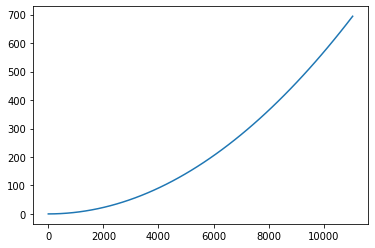

In [97]:
plt.plot(x0, z0)
plt.show()

In [98]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [99]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [100]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3],flag=1).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [106]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [107]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [108]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

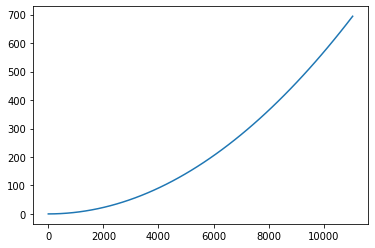

In [109]:
plt.plot(x0_, z0_)
plt.show()

In [110]:
init=1e-12
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.055*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([-0.0002*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [111]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [112]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [113]:
vehicle=semisub('DPcontrol',1,0,40.0,0,0) 

In [114]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [115]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

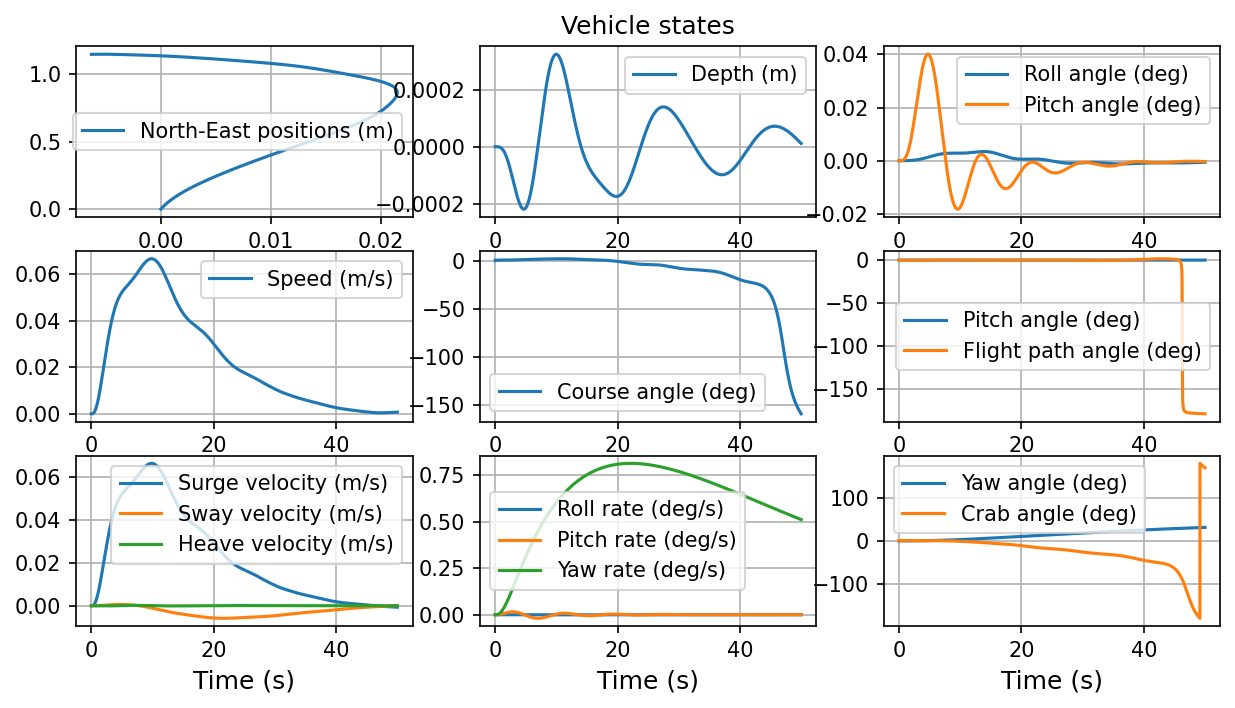

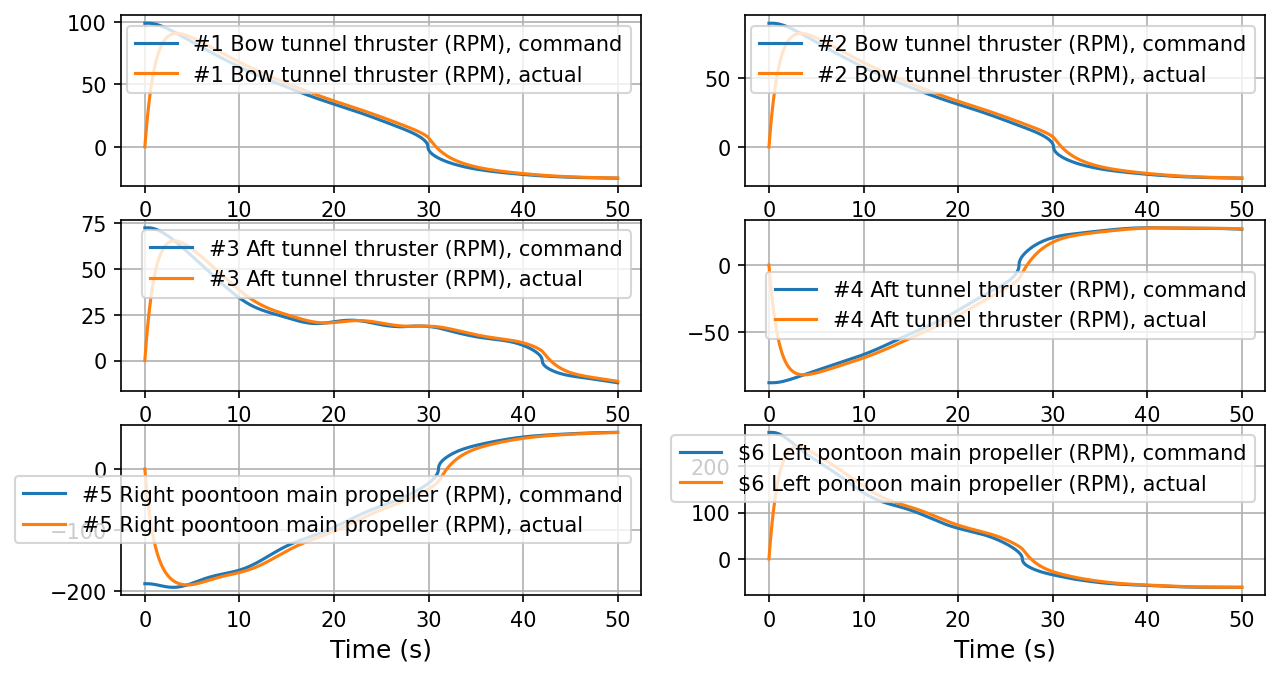

In [116]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [117]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

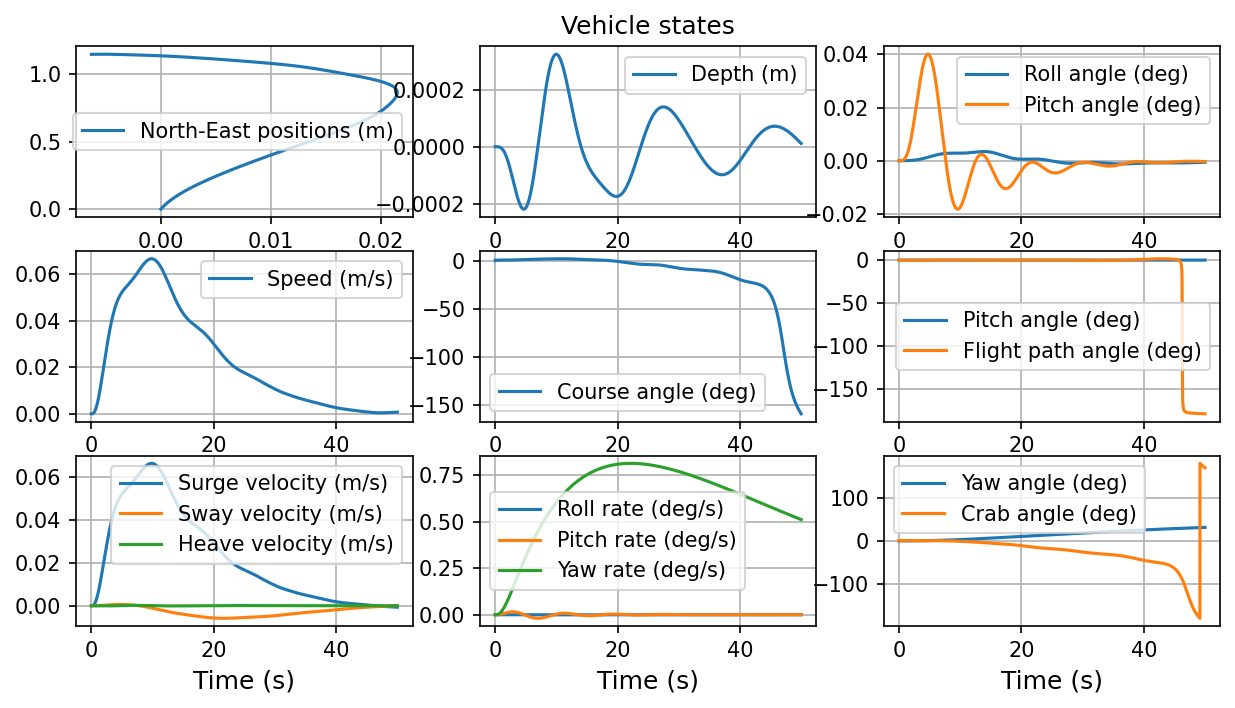

In [118]:
plotVehicleStates(simTime, simData, 3)

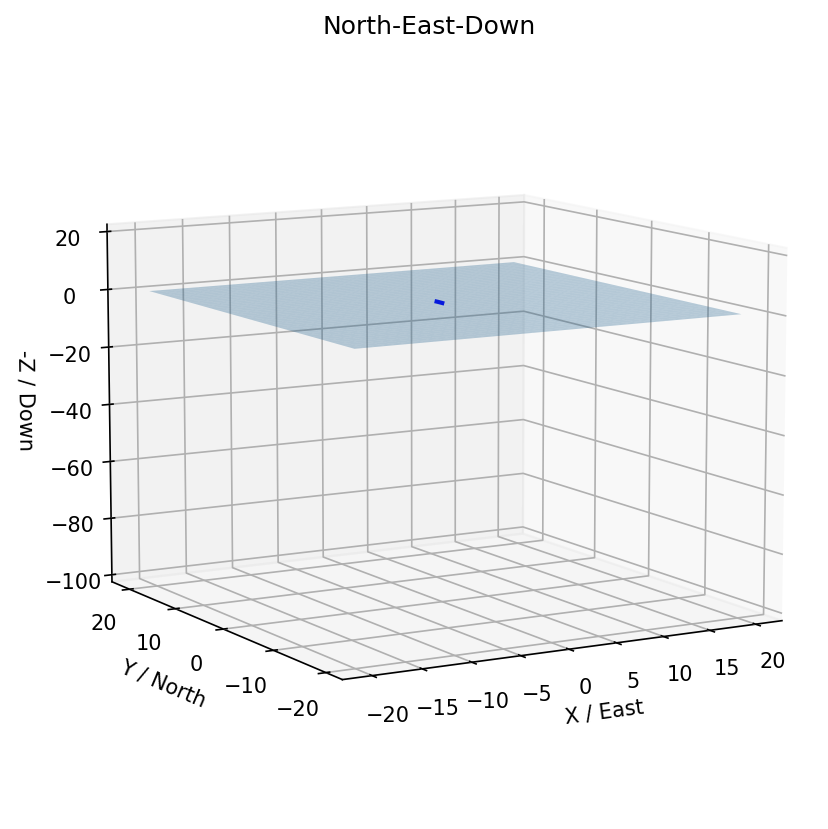

In [119]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [120]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [121]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [122]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

    
#     Z0=np.dot(Re_b(Ret.astype(np.float64)),tau_force[:3].astype(np.float64)).astype(np.float64)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3], flag=1).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 #+Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
   

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    
#     hack=1e15
    hack=1e18
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [147]:
tspan = (0., 15.5)

In [148]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:22.346822


In [149]:
# key takeaway: you can calibrate the model by tuning the hack and bc(init) 

### Results

In [150]:
fin=us

In [151]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1136
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.02865771e-02, 1.13152348e-01, 1.14181006e+00,
       1.87896167e+00, 2.61611329e+00, 3.68381710e+00, 4.98235550e+00,
       6.71006071e+00, 7.75240487e+00, 8.79474902e+00, 9.58248923e+00,
       1.02188935e+01, 1.07263727e+01, 1.11435109e+01, 1.15606491e+01,
       1.17108506e+01, 1.18610522e+01, 1.20172357e+01, 1.21734192e+01,
       1.22659618e+01, 1.23585043e+01, 1.24591717e+01, 1.25598390e+01,
       1.26037881e+01, 1.26477372e+01, 1.27419432e+01, 1.27809327e+01,
       1.28199221e+01, 1.28880008e+01, 1.29472676e+01, 1.30040839e+01,
       1.30499712e+01, 1.30948445e+01, 1.31428901e+01, 1.31917285e+01,
       1.32369459e+01, 1.32783785e+01, 1.33187725e+01, 1.33603066e+01,
       1.34033206e+01, 1.34460643e+01, 1.34868872e+01, 1.35253513e+01,
       1.35623519e+01, 1.35989639e+01, 

In [152]:
t=fin.t

In [153]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


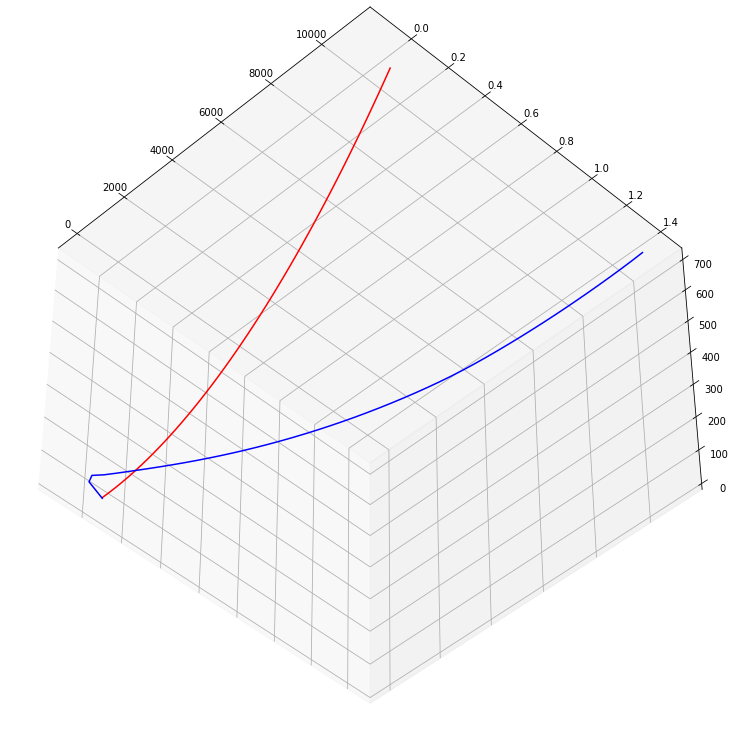

In [154]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [155]:
X,Y,Z

(array([    0.        ,   225.65373396,   451.39966732,   677.17254117,
          902.95681569,  1128.74650947,  1354.5388491 ,  1580.33245833,
         1806.12662751,  2031.92098708,  2257.71536826,  2483.50967482,
         2709.30386288,  2935.09793383,  3160.89191684,  3386.68576545,
         3612.47952616,  3838.27320554,  4064.06693237,  4289.86057157,
         4515.65412771,  4741.44763363,  4967.24110418,  5193.03455197,
         5418.82798796,  5644.62142707,  5870.41491164,  6096.2084578 ,
         6322.00207586,  6547.79576867,  6773.58945402,  6999.38311247,
         7225.17674182,  7450.97033759,  7676.76390621,  7902.55746512,
         8128.35105026,  8354.14466618,  8579.93831285,  8805.73198959,
         9031.52569512,  9257.31942741,  9483.11318378,  9708.9069589 ,
         9934.70074504, 10160.49454026, 10386.28834423, 10612.08216388,
        10837.87602845, 11063.66950781]),
 array([ 0.        , -0.09439725, -0.10807575, -0.07613663, -0.04907558,
        -0.02157181, 

In [156]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [157]:
us=fin.T

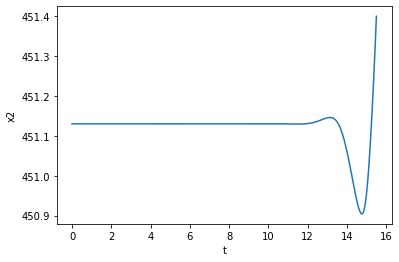

In [158]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

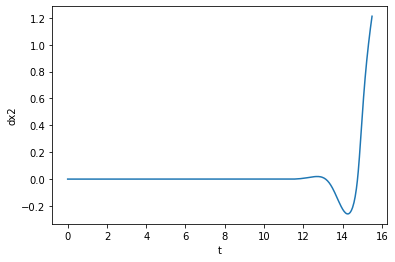

In [159]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

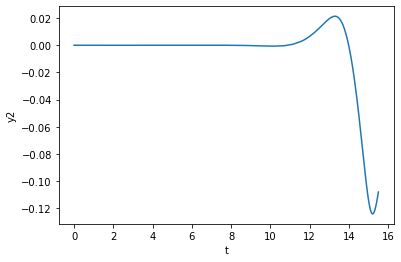

In [160]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

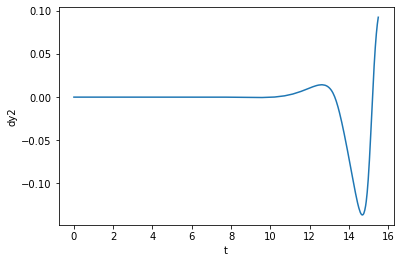

In [161]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

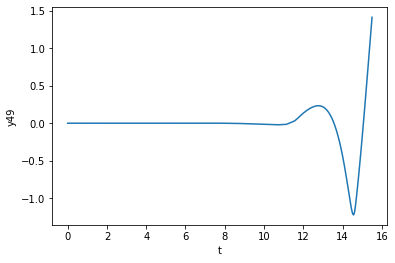

In [162]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

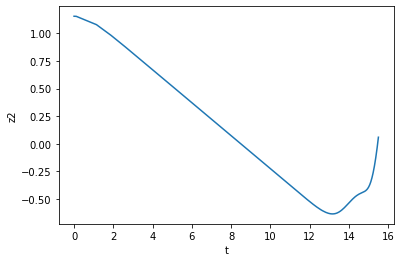

In [163]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

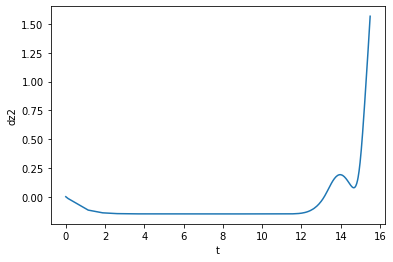

In [164]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

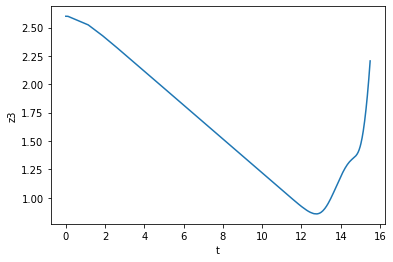

In [165]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

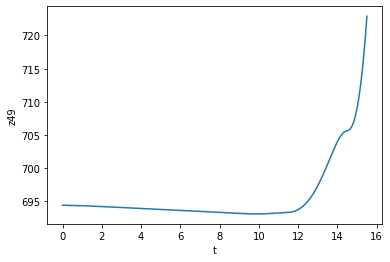

In [166]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

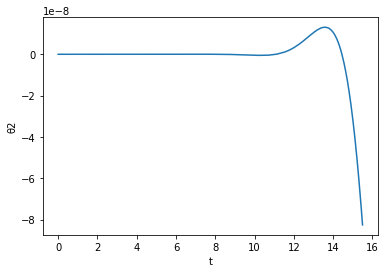

In [167]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

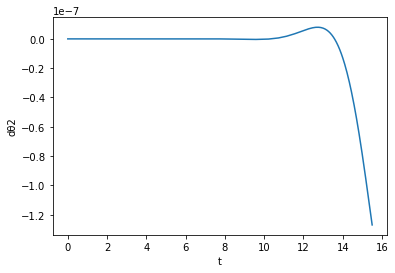

In [168]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

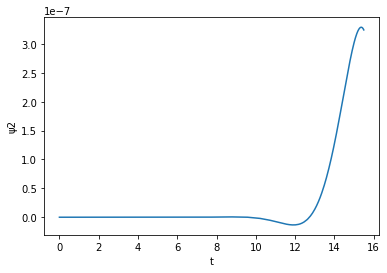

In [169]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

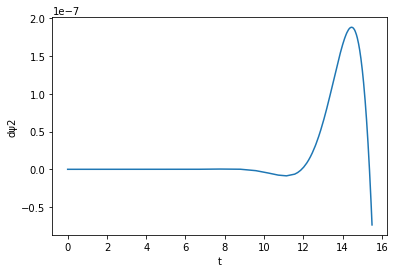

In [170]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()